In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from yellowbrick.target import FeatureCorrelation
from collections import defaultdict

In [2]:
tracks = pd.read_csv('../spotify_data.csv')
tracks['genre'] = tracks['genre'].str.strip().str.lower()

In [3]:
tracks.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)
tracks.dropna()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,1473391,Nicola Conte,Black Spirits,0m27F0IGHLGAWhqd6ccYst,4,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3
1159760,1473392,Nicola Conte,Quiet Dawn,6er9p611eHEcUCU50j7D57,3,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4
1159761,1473393,Amon Tobin,Morning Ms Candis,7jsMMqxy1tt0rH5FzYcZTQ,2,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4
1159762,1473394,Peace Orchestra,Happy Christmas (War Is Over),77lA1InUaXztuRk2vOzD1S,0,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3


In [4]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_ms', 'time_signature']

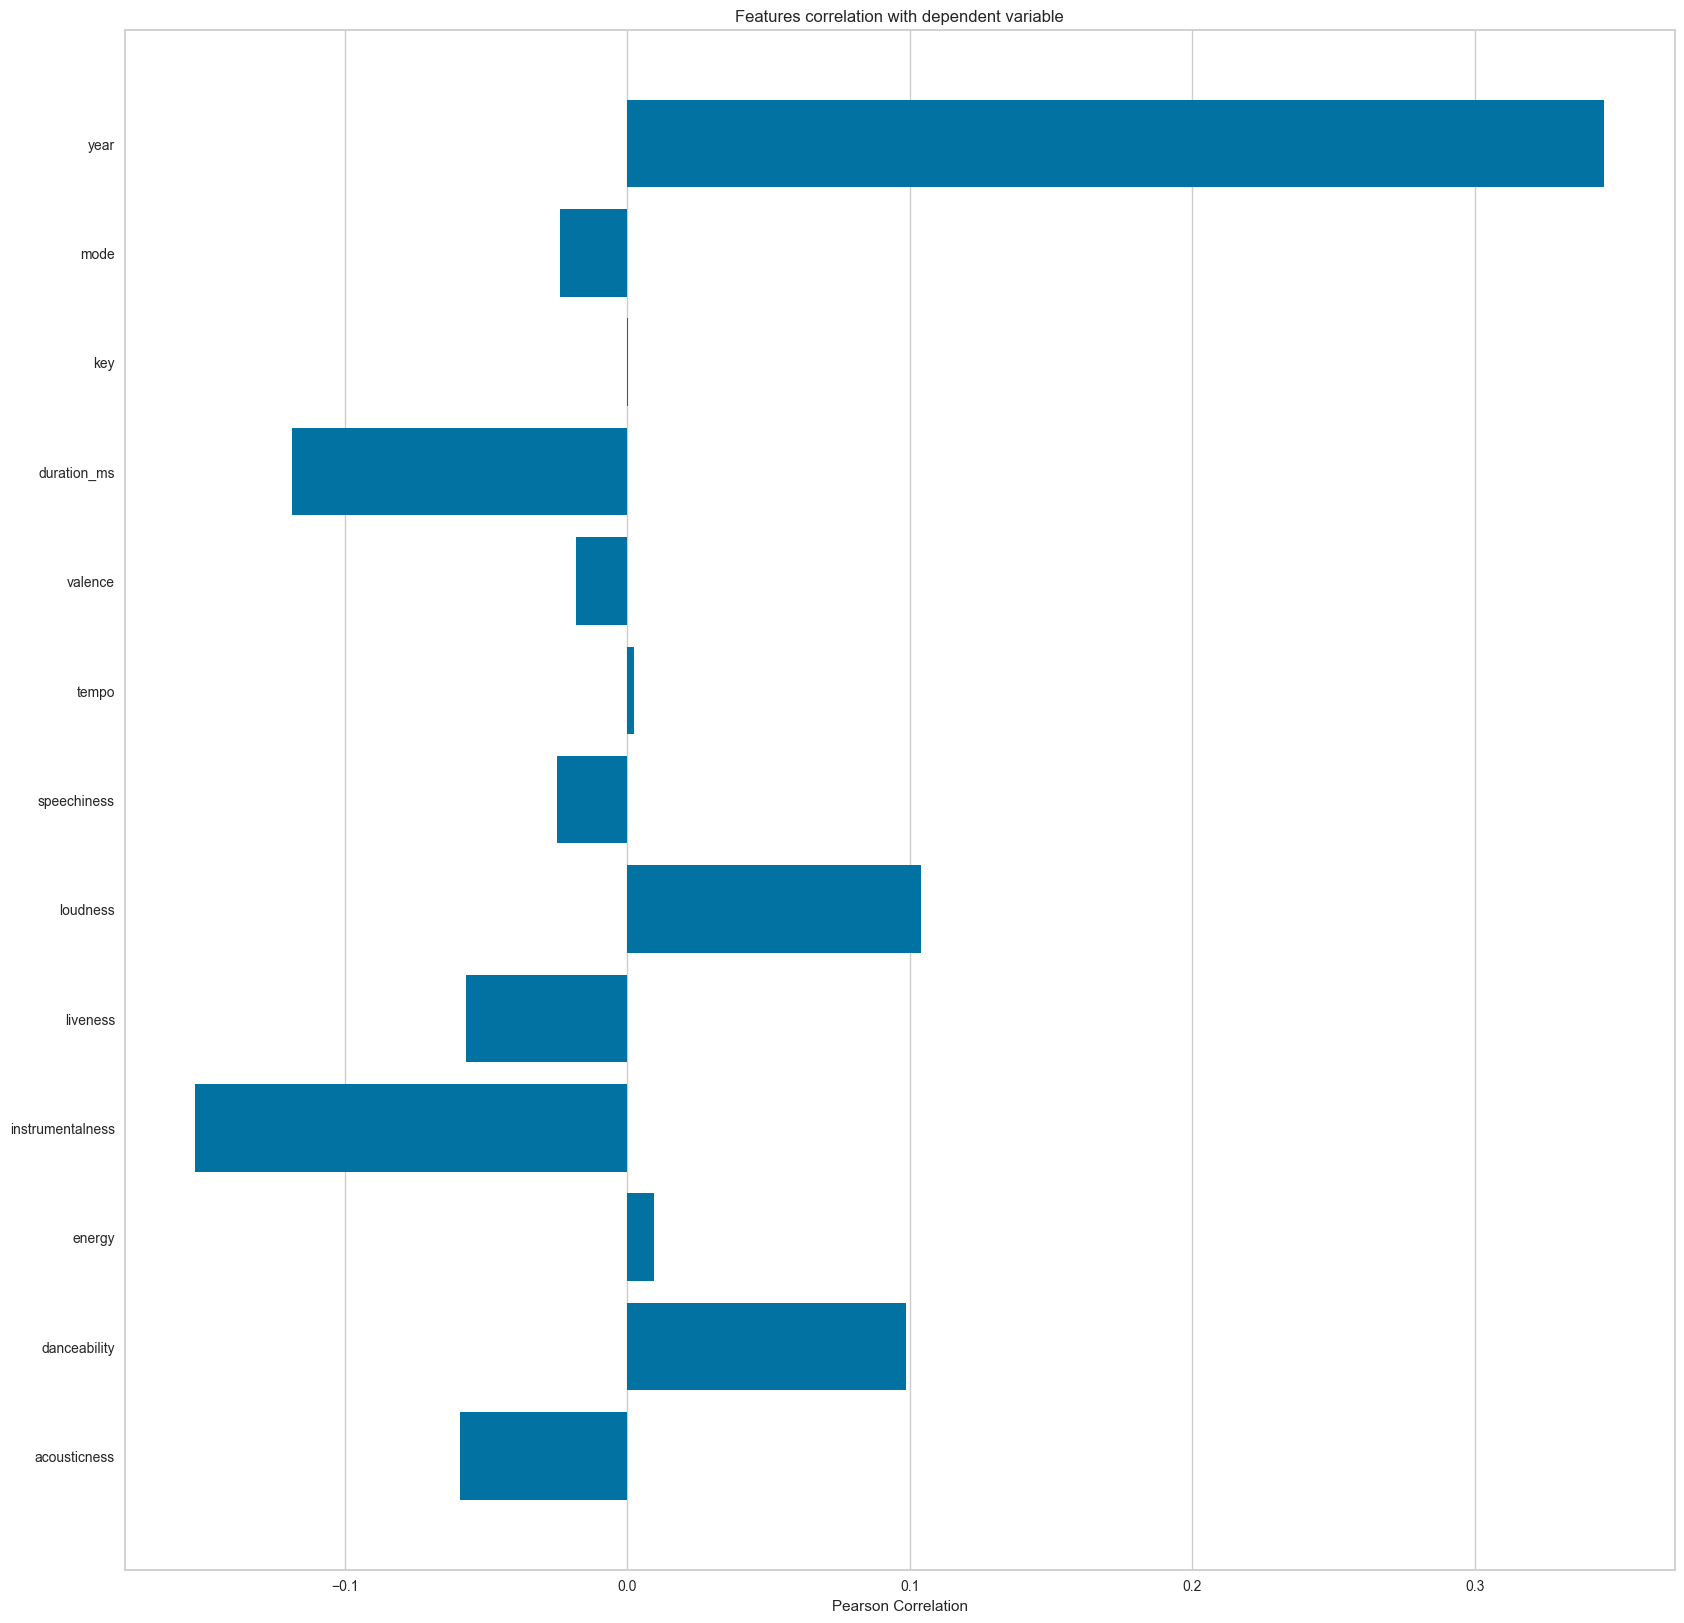

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [5]:
numericFeatures = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'key', 'mode', 'year']
X, y = tracks[numericFeatures], tracks['popularity']

features = np.array(numericFeatures)
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)
visualizer.show()

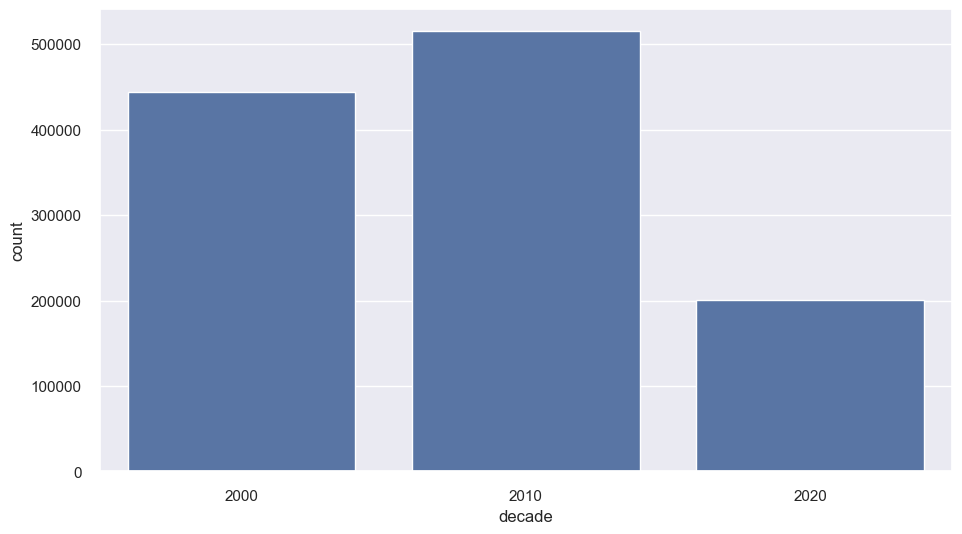

In [6]:
def getDecade(year):
    decade = int(year / 10) * 10
    return decade

tracks['decade'] = tracks['year'].apply(getDecade)


sns.set(rc={'figure.figsize':(11,6)})
sns.countplot(x='decade', data=tracks)

plt.show()

In [7]:
mean_metrics = tracks.nlargest(10, 'popularity')[['genre', 'valence', 'energy', 'danceability', 'acousticness']].groupby('genre').mean().reset_index()

fig = px.bar(mean_metrics, x='genre', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group', title="Average Metrics for Top 3 Genres")
fig.update_layout(yaxis_title="Metrics", xaxis_title="Genre", legend_title="Metrics")
fig.show()

In [8]:
scaler = StandardScaler()
scaledTracks = scaler.fit_transform(tracks[features])

In [9]:
birch = Birch(n_clusters=5)
birch.fit(scaledTracks[1:50000])
tracks['cluster'] = birch.predict(scaledTracks)

print(tracks.head())

   Unnamed: 0    artist_name        track_name                track_id  \
0           0     Jason Mraz   I Won't Give Up  53QF56cjZA9RTuuMZDrSA6   
1           1     Jason Mraz  93 Million Miles  1s8tP3jP4GZcyHDsjvw218   
2           2  Joshua Hyslop  Do Not Let Me Go  7BRCa8MPiyuvr2VU3O9W0F   
3           3   Boyce Avenue          Fast Car  63wsZUhUZLlh1OsyrZq7sz   
4           4   Andrew Belle  Sky's Still Blue  6nXIYClvJAfi6ujLiKqEq8   

   popularity  year     genre  danceability  energy  key  ...  speechiness  \
0          68  2012  acoustic         0.483   0.303    4  ...       0.0429   
1          50  2012  acoustic         0.572   0.454    3  ...       0.0258   
2          57  2012  acoustic         0.409   0.234    3  ...       0.0323   
3          58  2012  acoustic         0.392   0.251   10  ...       0.0363   
4          54  2012  acoustic         0.430   0.791    6  ...       0.0302   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0       

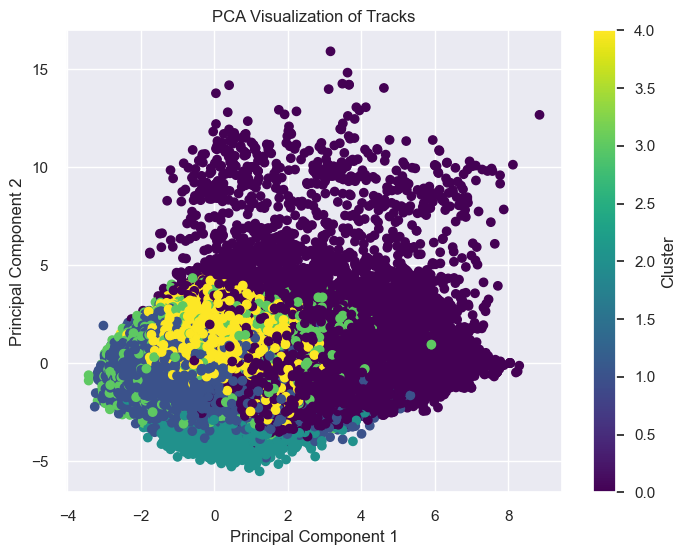

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaledTracks)

Df = pd.DataFrame(data=principalComponents,
                           columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([Df, tracks[['cluster']]], axis=1)

plt.figure(figsize=(8,6))
plt.scatter(Df['principal component 1'], Df['principal component 2'], c=tracks['cluster'].values, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.title('PCA Visualization of Tracks')

plt.show()

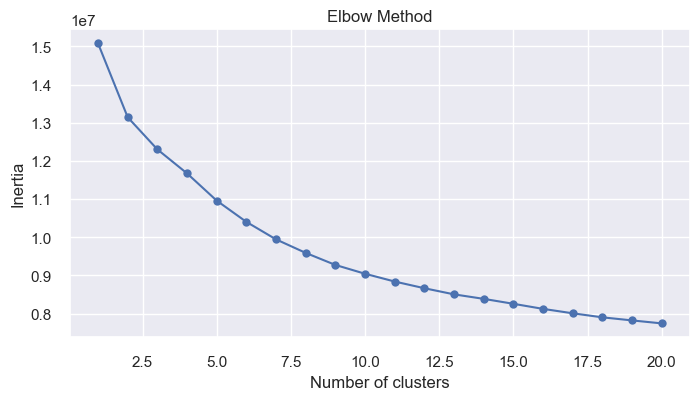

In [17]:
def find_optimal_clusters(data, features, max_k=20):
    scaled_data = scaler.fit_transform(data[features])
    inertia_arr = []

    
    for k in range(1, max_k + 1):
        birch = Birch(n_clusters=k)
        birch.fit(scaled_data[1:50000])

        labels = birch.predict(scaled_data)


        # Step 5: Calculate the cluster centroids
        centroids = np.array([scaled_data[labels == i].mean(axis=0) for i in range(k)])

        # Step 6: Compute the inertia (sum of squared distances to cluster centroids)
        inertia = 0
        for i in range(k):
            cluster_data = scaledTracks[labels == i]
            inertia += np.sum((cluster_data - centroids[i]) ** 2)




        inertia_arr.append(inertia)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), inertia_arr, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

find_optimal_clusters(tracks, features)

In [19]:
optimal_k = 5

birch = Birch(n_clusters=5)
scaledTracks = scaler.fit_transform(tracks[features])
tracks['cluster'] = birch.fit(scaledTracks[1:50000]).predict(scaledTracks)



In [21]:
def calculate_clustering_metrics(tracks, model, clusters):
    # print(features)
    # return tracks
    # Get the features and cluster labels
    X = tracks
    labels = model.labels_

    # Calculate Silhouette Score
    silhouette = silhouette_score(X, labels)
    
    # Calculate Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(X, labels)
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # Calculate average cosine similarity within clusters
    cosine_similarities = []
    for cluster in range(clusters):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            similarity = cosine_similarity(cluster_points).mean()
            cosine_similarities.append(similarity)
    average_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)

    return {
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin,
        'calinski_harabasz_score': calinski_harabasz,
        'average_cosine_similarity': average_cosine_similarity
    }

# calculate clustering metrics
metrics = calculate_clustering_metrics(scaledTracks[1:50000], birch, optimal_k)
print("Clustering Metrics:")
print(metrics)

Clustering Metrics:
{'silhouette_score': 0.1340594423787876, 'davies_bouldin_score': 1.8740086877329258, 'calinski_harabasz_score': 5565.568178219129, 'average_cosine_similarity': 0.42016107165336614}


In [40]:
def recommendSongs(inputTrackName, inputArtistName, tracks, features, scaler, birch, n_recommendations=10):
    inputTrackName = inputTrackName.strip().lower()
    inputArtistName = inputArtistName.strip().lower()

    # Find input track
    inputTrack = tracks[(tracks['track_name'].str.lower() == inputTrackName) & (tracks['artist_name'].str.lower() == inputArtistName)]

    if inputTrack.empty:
        print("Track not found in dataset")
        return pd.DataFrame()
    
    print("Input track found:")
    print(inputTrack)

    inputTrackFeatures = inputTrack[features]
    scaledInputTrackFeatures = scaler.transform(inputTrackFeatures)

    # Get the cluster of the input track
    inputCluster = inputTrack['cluster'].values[0]
    print(f"Predicted cluster: {inputCluster}")

    if inputCluster == -1:
        print("The input track is considered noise by Birch and does not belong to any cluster.")
        return pd.DataFrame()

    # Get tracks from the same cluster
    similarTracks = tracks[tracks['cluster'] == inputCluster]

    # Exclude input track from recommendations
    similarTracks = similarTracks[(similarTracks['track_name'].str.lower() != inputTrackName) | (similarTracks['artist_name'].str.lower() != inputArtistName)]

    # Calculate the distances to input track
    similarTracksFeatures = scaler.transform(similarTracks[features])
    distances = euclidean_distances(scaledInputTrackFeatures, similarTracksFeatures).flatten()

    # Add distances to the DataFrame
    similarTracks['distance'] = distances

    # Sort by distance and select top n_recommendations
    recommendations = similarTracks.sort_values(by=['distance', 'popularity'], ascending=[True, False]).drop_duplicates(subset=['artist_name', 'track_name']).head(n_recommendations)

    if len(recommendations) < n_recommendations:
        # Fill remaining recommendations with similar tracks if duplicates
        remaining = similarTracks[~similarTracks.index.isin(recommendations.index)].head(n_recommendations - len(recommendations))
        recommendations = pd.concat([recommendations, remaining])

    return recommendations[['artist_name', 'track_name', 'popularity', 'genre', 'year']]

In [47]:

# Get user input
inputTrackName = input("Enter track name: ")
inputArtistName = input("Enter artist name: ")

# Get recommendations
recommendations = recommendSongs(inputTrackName, inputArtistName, tracks, features, scaler, birch)

if recommendations.empty:
    print("No recommendations found")
else:
    print("Here are the top recommendations based on the inputted song:")
    print(recommendations[['artist_name', 'track_name', 'popularity', 'genre', 'year']])

Input track found:
        Unnamed: 0 artist_name track_name                track_id  popularity  \
340906      340906       Drake    Nonstop  0TlLq3lA83rQOYtrqBqSct          77   

        year    genre  danceability  energy  key  ...  speechiness  \
340906  2018  hip-hop         0.912   0.412    7  ...        0.123   

        acousticness  instrumentalness  liveness  valence    tempo  \
340906        0.0165            0.0126     0.104    0.423  154.983   

        duration_ms  time_signature  decade  cluster  
340906       238614               4    2010        1  

[1 rows x 22 columns]
Predicted cluster: 1
sijfdlskfj (574743, 22)
(574742,)
Here are the top recommendations based on the inputted song:
              artist_name                             track_name  popularity  \
244625         Young Thug  Special (feat. Offset and Solo Lucci)          40   
273396           OmenXIII                              I'm Sorry          26   
397885              Gunna                      